In [ ]:
import pandas as pd
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from typing import Union, List


os.chdir("C:/Users/jerem/OneDrive/Documents/rocketleague_ml")
file_name = "replay"
player_name = "CallMeBigSenior"
round = 1

field_x = [-4096, 4096, 4096, -4096, -4096]
field_y = [-5120, -5120, 5120, 5120, -5120]
processed_file = f"data/processed/pkl/{file_name}.pkl"

with open(processed_file, "rb") as f:
    game = pickle.load(f)

main_player = None
teammates: List[str] = []
opponents: List[str] = []
for player in game.players.values():
    if player.name == player_name:
        main_player = player
        break

if not main_player:
    raise ValueError("Could not find player {player_name}")

if not main_player.car:
    raise ValueError("Could not find player car {player_name}")

for player in game.players.values():
    if player.name == player_name:
        continue
    if player.team == main_player.team:
        teammates.append(player.name)
    else:
        opponents.append(player.name)

flip_x = True
flip_y = True if main_player and main_player.team == "Blue" else False

# Positioning

In [2]:
dense = pd.DataFrame({"time": [frame["time"] for frame in game.frames], "delta": [frame["delta"] for frame in game.frames], "active": [frame["active"] or False for frame in game.frames]})
dense.set_index("time", drop=False, inplace=True)

# --- ball ---
ball_ser = pd.DataFrame(
    {u["time"]: ((-1 if flip_x else 1) * u["location"]["x"], (-1 if flip_y else 1) * u["location"]["y"], u["location"]["z"])
     for u in game.ball.updates_by_round[round]}
).T.rename(columns={0: "ball_x", 1: "ball_y", 2: "ball_z"})

# reindex onto master frame list
ball_ser = ball_ser.reindex(dense.index, method="ffill")
for col in ball_ser.columns:
    dense[col] = ball_ser[col]

# --- players ---
for player in game.players.values():
    if not player.car:
        continue
    prefix = player.name + "_"
    if player.name == player_name:
        prefix = ""
    player_ser = pd.DataFrame(
        {u["time"]: ((-1 if flip_x else 1) * u["location"]["x"], (-1 if flip_y else 1) * u["location"]["y"], u["location"]["z"])
         for u in player.car.updates_by_round[round]}
    ).T.rename(columns={0: f"{prefix}x", 1: f"{prefix}y", 2: f"{prefix}z"})

    player_ser = player_ser.reindex(dense.index, method="ffill")
    for col in player_ser.columns:
        dense[col] = player_ser[col]

# --- drop rows where all position columns are NaN ---
pos_cols = [c for c in dense.columns if c != "time"]

# mask for rows that have at least one position
mask_pos = dense[pos_cols].notna().any(axis=1)

# mask for rows that are active
mask_active = dense["active"] == True

# combined mask
mask = mask_pos & mask_active

# find the first and last "valid" indices
valid_index = mask[mask].index  # Index of rows where mask is True
first_valid = valid_index[0]
last_valid = valid_index[-1]

# slice the DataFrame to keep only that range
dense = dense.loc[first_valid:last_valid].reset_index(drop=True)

# now you can ffill/bfill safely
dense = dense.ffill().bfill()


# --- distance to other players ---
for player in game.players.values():
    if player.name == player_name:
        continue
    dense[f"distance_to_{player.name}"] = np.sqrt(
        (dense["x"] - dense[f"{player.name}_x"]) ** 2 +
        (dense["y"] - dense[f"{player.name}_y"]) ** 2 +
        (dense["z"] - dense[f"{player.name}_z"]) ** 2
    )


### Calculate Player Distances to Ball

In [3]:
dense["distance_to_ball"] = np.sqrt(
    (dense["x"] - dense["ball_x"]) ** 2 +
    (dense["y"] - dense["ball_y"]) ** 2 +
    (dense["z"] - dense["ball_z"]) ** 2
)

for player in game.players.values():
    if player.name == player_name:
        continue
    dense[f"{player.name}_distance_to_ball"] = np.sqrt(
        (dense[f"{player.name}_x"] - dense["ball_x"]) ** 2 +
        (dense[f"{player.name}_y"] - dense["ball_y"]) ** 2 +
        (dense[f"{player.name}_z"] - dense["ball_z"]) ** 2
    )

## Field Positioning

In [ ]:
max_y = abs(field_y[0])
third_of_y = max_y / 3
dense["offensive_half"] = dense["y"] > 0
dense["defensive_half"] = dense["y"] <= 0
dense["offensive_third"] = dense["y"] >= third_of_y
dense["neutral_third"] = (dense["y"] < third_of_y) & (dense["y"] > -third_of_y)
dense["defensive_third"] = dense["y"] <= -third_of_y

dense["left_half"] = dense["x"] > 0
dense["right_half"] = dense["x"] <= 0
dense["left_third"] = dense["x"] >= third_of_y
dense["middle_third"] = (dense["x"] < third_of_y) & (dense["x"] > -third_of_y)
dense["right_third"] = dense["x"] <= -third_of_y

distance_cols = [c for c in dense.columns if c.endswith("_distance_to_ball") or c == "distance_to_ball"]
dense["closest_to_ball"] = dense["distance_to_ball"] == dense[distance_cols].min(axis=1)
dense["farthest_from_ball"] = dense["distance_to_ball"] == dense[distance_cols].max(axis=1)
dense["in_front_of_ball"] = dense["y"] > dense["ball_y"] 
dense["behind_ball"] = dense["y"] < dense["ball_y"]

# tolerances so we don't misclassify tiny bounces
Z_GROUND = 30
Z_CEILING = 2000
X_WALL = 4096
Y_WALL = 5120
X_GOAL = 892
GOAL_DEPTH = 880
TOL = 50  # tolerance in uu

dense["grounded"] = dense["z"].between(0, Z_GROUND) # type: ignore
dense["on_ceiling"] = dense["z"] >= Z_CEILING

dense["on_left_wall"] = dense["x"] <= -X_WALL + TOL
dense["on_right_wall"] = dense["x"] >= X_WALL - TOL

# Goal regions
dense["in_own_goal"] = (
    (dense["x"].between(-X_GOAL, X_GOAL)) & # type: ignore
    (dense["y"] <= -(Y_WALL - TOL)) &
    (dense["y"] >= -(Y_WALL + GOAL_DEPTH + TOL))
)
dense["in_opponents_goal"] = (
    (dense["x"].between(-X_GOAL, X_GOAL)) & # type: ignore
    (dense["y"] >= (Y_WALL - TOL)) &
    (dense["y"] <= (Y_WALL + GOAL_DEPTH + TOL))
)

# Wall checks, excluding goal occupancy
dense["on_back_wall"] = (
    (dense["y"] <= -(Y_WALL - TOL)) &
    (~dense["in_own_goal"])
)
dense["on_front_wall"] = (
    (dense["y"] >= (Y_WALL - TOL)) &
    (~dense["in_opponents_goal"])
)

# airborne = none of the above
dense["airborne"] = ~(
    dense["grounded"] |
    dense["on_ceiling"] |
    dense["on_left_wall"] |
    dense["on_right_wall"] |
    dense["on_back_wall"] |
    dense["on_front_wall"]
)

dense.head().T

,0,1,2,3,4
time,21.390148,21.425114,21.46008,21.495043,21.53001
delta,0.034966,0.034966,0.034966,0.034966,0.034966
active,True,True,True,True,True
ball_x,0.0,0.0,0.0,0.0,0.0
ball_y,0.0,0.0,0.0,0.0,0.0
ball_z,93.0,93.0,93.0,93.0,93.0
x,0.0,-0.0,-0.0,0.01,0.01
y,4608.0,4607.46,4607.46,4596.44,4596.44
z,17.0,17.01,17.01,17.01,17.01
Tootew_x,256.0,256.0,256.0,255.97,255.97


In [5]:
dense.tail().T

,9629,9630,9631,9632,9633
time,377.11,377.14493,377.17987,377.2148,377.24976
delta,0.034966,0.034966,0.034966,0.034966,0.034966
active,True,True,True,True,True
ball_x,-541.3,-541.3,-541.3,-541.3,-541.3
ball_y,-5108.1,-5108.1,-5108.1,-5108.1,-5108.1
ball_z,255.09,255.09,255.09,255.09,255.09
x,-488.57,-488.57,-488.57,-488.57,-488.57
y,-4628.97,-4628.97,-4628.97,-4628.97,-4628.97
z,612.2,612.2,612.2,612.2,612.2
Tootew_x,2627.55,2627.55,2627.55,2627.55,2627.55


# Calculate Summary Metrics

In [6]:
dense.describe().T

,count,mean,std,min,25%,50%,75%,max
time,9634.0,197.422200,104.698488,21.390148,106.636172,190.887570,293.033367,377.249760
delta,9634.0,0.034990,0.000750,0.000000,0.034966,0.034966,0.034966,0.048332
ball_x,9634.0,-475.574628,1022.773521,-4008.660000,-541.300000,-541.300000,-541.300000,4003.510000
ball_y,9634.0,-4062.473609,2537.150445,-5108.100000,-5108.100000,-5108.100000,-5108.100000,5023.040000
ball_z,9634.0,317.228462,239.215828,89.980000,255.090000,255.090000,255.090000,1936.170000
x,9634.0,-459.237010,856.017320,-4079.060000,-488.570000,-488.570000,-488.570000,3621.310000
y,9634.0,-3418.928298,2876.432582,-5982.400000,-4628.970000,-4628.970000,-4628.970000,5622.860000
z,9634.0,522.764657,206.497716,11.010000,612.200000,612.200000,612.200000,656.920000
Tootew_x,9634.0,2283.212795,1157.629222,-3062.220000,2627.550000,2627.550000,2627.550000,4083.210000
Tootew_y,9634.0,-3183.918404,1567.217413,-5104.200000,-3674.270000,-3674.270000,-3674.270000,5141.950000


In [7]:
def get_position_stats_for(cols: Union[str, List[str]]):
    total_time = dense["delta"].sum()

    # build mask
    if isinstance(cols, str):
        mask = dense[cols]
    else:
        mask = dense[cols].all(axis=1)   # AND across provided columns

    # percentage time
    time_in_position = dense.loc[mask, "delta"].sum()
    perc_in_position = time_in_position / total_time if total_time > 0 else 0

    # find runs/stints
    run_ids = mask.ne(mask.shift()).cumsum()
    stint_groups = dense[mask].groupby(run_ids) # type: ignore

    # duration per stint
    stint_durations = stint_groups["delta"].sum()

    # average stint duration
    avg_stint = stint_durations.mean() if not stint_durations.empty else 0

    return perc_in_position, avg_stint

In [8]:
perc_offensive, avg_offensive_stint = get_position_stats_for("offensive_half")
perc_defensive, avg_defensive_stint = get_position_stats_for("defensive_half")

perc_offensive_third, avg_offensive_third_stint = get_position_stats_for(
    "offensive_third"
)
perc_neutral_third, avg_neutral_third_stint = get_position_stats_for("neutral_third")
perc_defensive_third, avg_defensive_third_stint = get_position_stats_for(
    "defensive_third"
)

summary = pd.DataFrame(
    {
        "Labels": [
            "Percentage Time in Offensive Half",
            "Average Stint of Time in Offensive Half",
            "Percentage Time in Defensive Half",
            "Average Stint of Time in Defensive Half",
            "Percentage Time in Offensive Third",
            "Average Stint in Offensive Third",
            "Percentage Time in Neutral Third",
            "Average Stint in Neutral Third",
            "Percentage Time in Defensive Third",
            "Average Stint in Defensive Third",
        ],
        "Metrics": [
            f"{perc_offensive:.2%}",
            f"{avg_offensive_stint:.2f}",
            f"{perc_defensive:.2%}",
            f"{avg_defensive_stint:.2f}",
            f"{perc_offensive_third:.2%}",
            f"{avg_offensive_third_stint:.2f}",
            f"{perc_neutral_third:.2%}",
            f"{avg_neutral_third_stint:.2f}",
            f"{perc_defensive_third:.2%}",
            f"{avg_defensive_third_stint:.2f}",
        ],
    }
)
summary

,Labels,Metrics
0,Percentage Time in Offensive Half,14.70%
1,Average Stint of Time in Offensive Half,16.52
2,Percentage Time in Defensive Half,85.30%
3,Average Stint of Time in Defensive Half,95.85
4,Percentage Time in Offensive Third,12.09%
5,Average Stint in Offensive Third,10.19
6,Percentage Time in Neutral Third,3.48%
7,Average Stint in Neutral Third,2.34
8,Percentage Time in Defensive Third,84.44%
9,Average Stint in Defensive Third,142.31


In [9]:
perc_left, avg_left_stint = get_position_stats_for("left_half")
perc_right, avg_right_stint = get_position_stats_for("right_half")

perc_left_third, avg_left_third_stint = get_position_stats_for("left_third")
perc_middle_third, avg_middle_third_stint = get_position_stats_for("middle_third")
perc_right_third, avg_right_third_stint = get_position_stats_for("right_third")

In [10]:
perc_offensive_left, avg_offensive_left_stint = get_position_stats_for(["offensive_half", "left_half"])
perc_offensive_right, avg_offensive_right_stint = get_position_stats_for(["offensive_half", "right_half"])
perc_defensive_left, avg_defensive_left_stint = get_position_stats_for(["defensive_half", "left_half"])
perc_defensive_right, avg_defensive_right_stint = get_position_stats_for(["defensive_half", "right_half"])

In [11]:
perc_offensive_left_third, avg_offensive_left_third_stint = get_position_stats_for(["offensive_third", "left_third"])
perc_offensive_middle_third, avg_offensive_middle_third_stint = get_position_stats_for(["offensive_third", "middle_third"])
perc_offensive_right_third, avg_offensive_right_third_stint = get_position_stats_for(["offensive_third", "right_third"])

perc_neutral_left_third, avg_neutral_left_third_stint = get_position_stats_for(["neutral_third", "left_third"])
perc_neutral_middle_third, avg_neutral_middle_third_stint = get_position_stats_for(["neutral_third", "middle_third"])
perc_neutral_right_third, avg_neutral_right_third_stint = get_position_stats_for(["neutral_third", "right_third"])

perc_defensive_left_third, avg_defensive_left_third_stint = get_position_stats_for(["defensive_third", "left_third"])
perc_defensive_middle_third, avg_defensive_middle_third_stint = get_position_stats_for(["defensive_third", "middle_third"])
perc_defensive_right_third, avg_defensive_right_third_stint = get_position_stats_for(["defensive_third", "right_third"])

In [12]:
perc_closest, avg_closest_stint = get_position_stats_for("closest_to_ball")
perc_farthest, avg_farthest_stint = get_position_stats_for("farthest_from_ball")
perc_in_front, avg_in_front_stint = get_position_stats_for("in_front_of_ball")
perc_behind, avg_behind_stint = get_position_stats_for("behind_ball")

In [13]:
perc_grounded, avg_grounded_stint = get_position_stats_for("grounded")
perc_airborne, avg_airborne_stint = get_position_stats_for("airborne")
perc_on_ceiling, avg_on_ceiling_stint = get_position_stats_for("on_ceiling")
perc_on_left_wall, avg_on_left_wall_stint = get_position_stats_for("on_left_wall")
perc_on_right_wall, avg_on_right_wall_stint = get_position_stats_for("on_right_wall")
perc_on_back_wall, avg_on_back_wall_stint = get_position_stats_for("on_back_wall")
perc_on_front_wall, avg_on_front_wall_stint = get_position_stats_for("on_front_wall")
perc_in_own_goal, avg_in_own_goal_stint = get_position_stats_for("in_own_goal")
perc_in_opponents_goal, avg_in_opponents_goal_stint = get_position_stats_for("in_opponents_goal")

In [14]:
avg_distance_to_ball = dense["distance_to_ball"].mean()
teammate_distances = [f"distance_to_{teammate}" for teammate in teammates]
avg_distance_to_teammates = dense[teammate_distances].mean(axis=1).mean()
avg_distance_to_teammate_1 = dense[teammate_distances[0]].mean()
avg_distance_to_teammate_2 = dense[teammate_distances[1]].mean()
opponent_distances = [f"distance_to_{opponent}" for opponent in opponents]
avg_distance_to_opponents = dense[opponent_distances].mean(axis=1).mean()
avg_distance_to_opponent_1 = dense[opponent_distances[0]].mean()
avg_distance_to_opponent_2 = dense[opponent_distances[1]].mean()
avg_distance_to_opponent_3 = dense[opponent_distances[2]].mean()

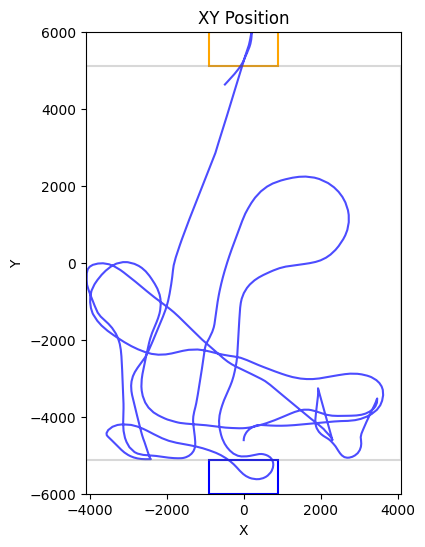

In [17]:
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(9, 6))

# plot player positions
ax.plot(dense["x"], -dense["y"], color="blue", alpha=0.7)

ax.plot(field_x, field_y, color="grey", alpha=0.3)

# Goal dimensions (approx in UU)
goal_width = 1786  # post-to-post (x)
goal_depth = 880   # into the field (y)

# Blue goal (at y = -5120, facing upfield)
blue_goal = patches.Rectangle(
    (-goal_width/2, -5120 - goal_depth),  # bottom-left corner
    goal_width,
    goal_depth,
    linewidth=1.5,
    edgecolor="blue",
    facecolor="none"
)
ax.add_patch(blue_goal)

# Orange goal (at y = +5120, facing downfield)
orange_goal = patches.Rectangle(
    (-goal_width/2, 5120),  # bottom-left corner
    goal_width,
    goal_depth,
    linewidth=1.5,
    edgecolor="orange",
    facecolor="none"
)
ax.add_patch(orange_goal)

ax.set_title("XY Position")
ax.set_xlabel("X")
ax.set_ylabel("Y")

ax.set_aspect("equal", "box")
ax.set_xlim(field_x[0], field_x[1])
ax.set_ylim(-6000, 6000)

plt.show()


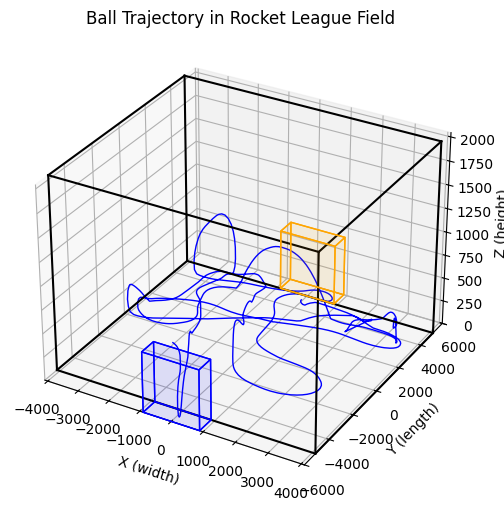

In [16]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection="3d")
ax.plot(dense["x"], dense["y"], dense["z"], markersize=2, linewidth=1, color="blue")

# Draw field outline (wireframe)
field_x_3D = [-4096, 4096]
field_y_3D = [-5120, 5120]
field_z_3D = [0, 2044]

# Helper to draw goal as wireframe box
def draw_goal(ax, y_center, color="red", alpha=0.2):
    # Corners of the goal
    x0, x1 = -X_GOAL, X_GOAL
    y0, y1 = y_center, y_center + (GOAL_DEPTH if y_center > 0 else -GOAL_DEPTH)
    z0, z1 = [0, 642]

    # 8 vertices of goal box
    verts = [
        [x0, y0, z0],
        [x1, y0, z0],
        [x1, y1, z0],
        [x0, y1, z0],
        [x0, y0, z1],
        [x1, y0, z1],
        [x1, y1, z1],
        [x0, y1, z1],
    ]

    # 6 faces
    faces = [
        [verts[i] for i in [0, 1, 2, 3]],  # bottom
        [verts[i] for i in [4, 5, 6, 7]],  # top
        [verts[i] for i in [0, 1, 5, 4]],  # front
        [verts[i] for i in [2, 3, 7, 6]],  # back
        [verts[i] for i in [1, 2, 6, 5]],  # right
        [verts[i] for i in [0, 3, 7, 4]],  # left
    ]

    ax.add_collection3d(Poly3DCollection(faces, facecolors=color, linewidths=1, edgecolors=color, alpha=alpha))

# Draw goals
draw_goal(ax, Y_WALL, color="orange", alpha=0.05)    # Opponent's goal
draw_goal(ax, -Y_WALL, color="blue", alpha=0.05)

# 12 edges of the field box
for x in field_x_3D:
    for y in field_y_3D:
        ax.plot([x, x], [y, y], field_z_3D, color="black")  # verticals
for z in field_z_3D:
    ax.plot(
        field_x_3D, [field_y_3D[0], field_y_3D[0]], [z, z], color="black"
    )  # front/back X edges
    ax.plot(field_x_3D, [field_y_3D[1], field_y_3D[1]], [z, z], color="black")
    ax.plot(
        [field_x_3D[0], field_x_3D[0]], field_y_3D, [z, z], color="black"
    )  # left/right Y edges
    ax.plot([field_x_3D[1], field_x_3D[1]], field_y_3D, [z, z], color="black")

ax.set_title("Ball Trajectory in Rocket League Field")
ax.set_xlabel("X (width)")
ax.set_ylabel("Y (length)")
ax.set_zlabel("Z (height)")

# Set field limits
ax.set_xlim(field_x_3D)
ax.set_ylim(-6000, 6000)
ax.set_zlim(field_z_3D)
plt.show()
